<a href="https://colab.research.google.com/github/Kitsunnneee/Common-Task-1/blob/main/Common_Task_1(VAE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Neccessary Dependencies

In [ ]:
import numpy as np
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from keras.callbacks import EarlyStopping
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mounting Data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5" #Path to the dataset on my google drive

with h5py.File(path, 'r') as f:
  print(f"Keys: {list(f.keys())}")
  X_jets = f['X_jets'][0:5000] # Working with only a subset of data due to computational limits
  print(f"X_jets shape : {X_jets.shape}") # printing the shape of the images and amount

Keys: ['X_jets', 'm0', 'pt', 'y']
X_jets shape : (5000, 125, 125, 3)


In [ ]:
X_jets_resized = np.zeros((X_jets.shape[0], 128, 128, 3)) # resizing the data to 128 x 128
for i in range(X_jets.shape[0]):
    X_jets_resized[i] = smart_resize(X_jets[i],(128,128))

X_jets = X_jets_resized
del(X_jets_resized)

# Preprocessing the data

In [ ]:
print("Previous min, max and mean :-")  #Printing the mean , max and min of the images
print(np.min(X_jets))
print(np.max(X_jets))
print(np.mean(X_jets))

X_jets = (X_jets - X_jets.min()) / (X_jets.max() - X_jets.min())  # Normalizing the data using min-max scaler technique

print("\nAfter normalization min, max and mean :-") # Values after normalization
print(np.min(X_jets))
print(np.max(X_jets))
print(np.mean(X_jets))

Previous min, max and mean :-
0.0
2.950078010559082
5.2944115734619886e-05

After normalization min, max and mean :-
0.0
1.0
1.794668328943137e-05


In [ ]:
# Normalize Track, ECAL, HCAL data
mean_track = np.mean(X_jets[:,:,:,0])
std_track = np.std(X_jets[:,:,:,0])
normalized_track = (X_jets[:,:,:,0] - mean_track) / std_track

mean_ecal = np.mean(X_jets[:,:,:,1])
std_ecal = np.std(X_jets[:,:,:,1])
normalized_ecal = (X_jets[:,:,:,1] - mean_ecal) / std_ecal

mean_hcal = np.mean(X_jets[:,:,:,2])
std_hcal = np.std(X_jets[:,:,:,2])
normalized_hcal = (X_jets[:,:,:,2] - mean_hcal) / std_hcal


combined = normalized_track + normalized_ecal + normalized_hcal
combined.shape

(5000, 128, 128)

## Functions to plot the different Channels

In [ ]:
def plot_track_images(track, img_num=3):

    fig, axes = plt.subplots(1, img_num, figsize = (20,20))
    for i in range(img_num):
        temp = axes[i].imshow(track[i], cmap = 'viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
        axes[i].axis('off')
        axes[i].set_title('Track : {}'.format(i+1))
        fig.colorbar(temp, ax=axes[i], shrink=0.25)
    plt.show()

def plot_ecal_images(ecal, img_num=3):
    fig, axes = plt.subplots(1, img_num, figsize = (20,20))
    for i in range(img_num):
        temp = axes[i].imshow(ecal[i], cmap = 'viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
        axes[i].axis('off')
        axes[i].set_title('ECAL : {}'.format(i+1))
        fig.colorbar(temp, ax=axes[i], shrink=0.25)
    plt.show()

def plot_hcal_images(hcal, img_num=3):
    fig, axes = plt.subplots(1, img_num, figsize = (20,20))
    for i in range(img_num):
        temp = axes[i].imshow(hcal[i], cmap = 'viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
        axes[i].axis('off')
        axes[i].set_title('HCAL : {}'.format(i+1))
        fig.colorbar(temp, ax=axes[i], shrink=0.25)
    plt.show()


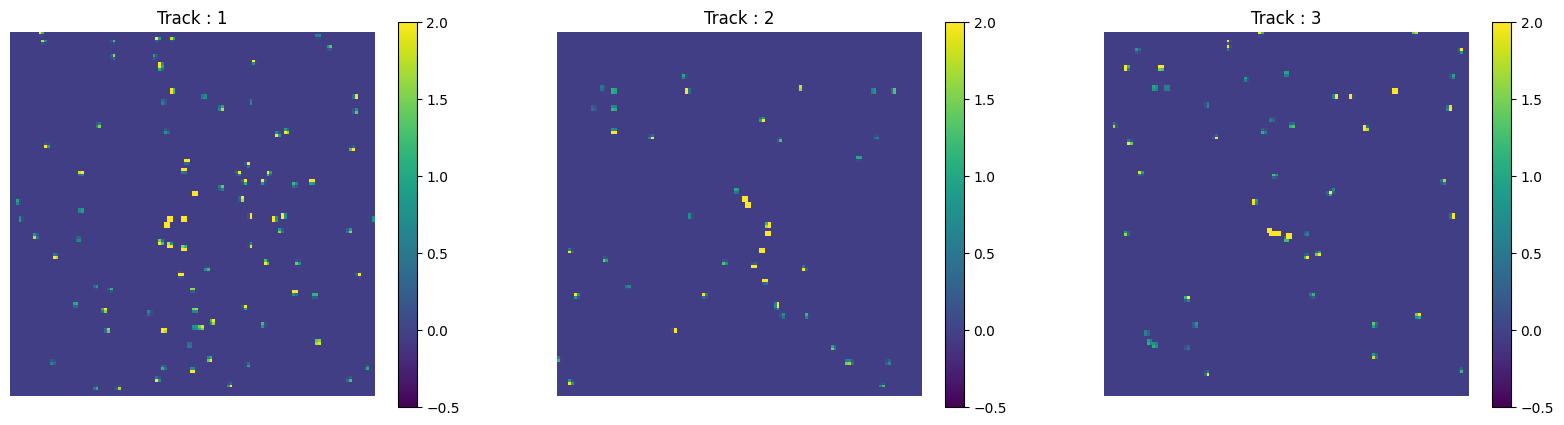

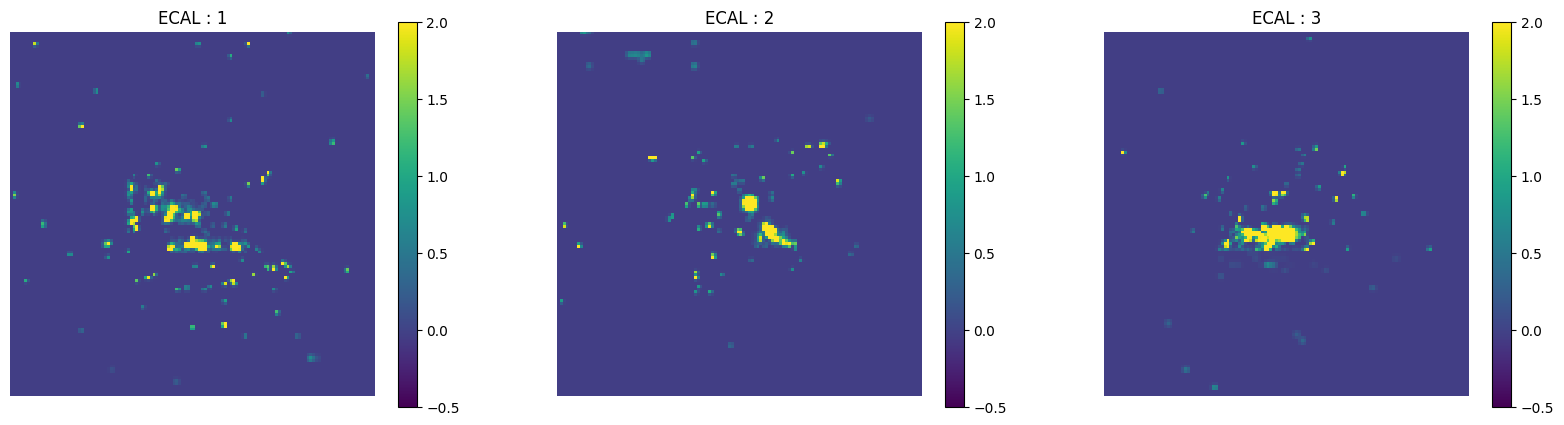

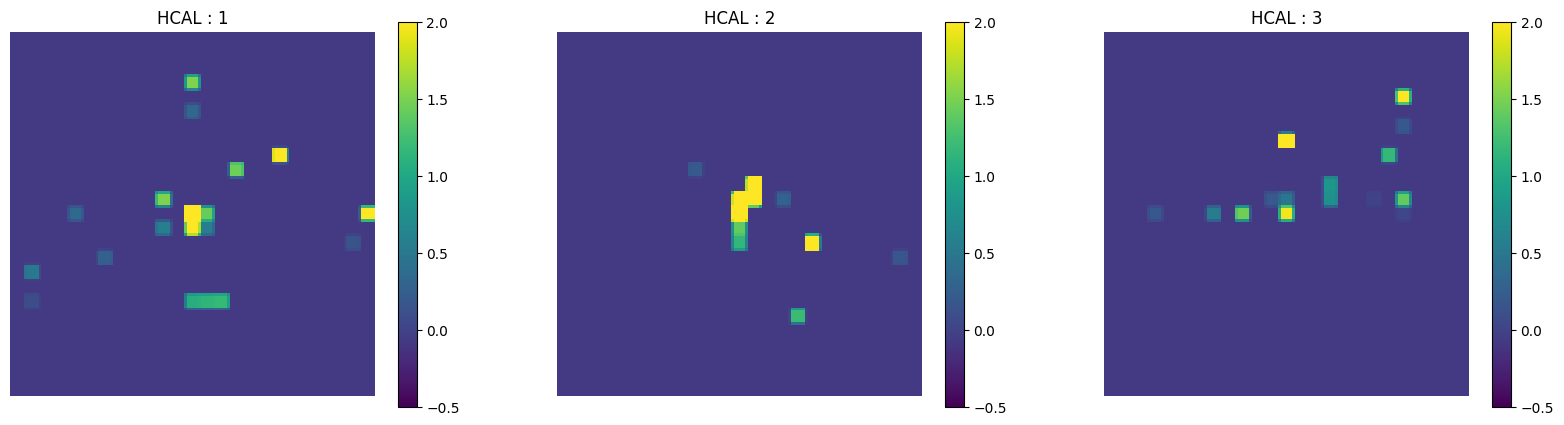

In [ ]:
plot_track_images(normalized_track, 3)
plot_ecal_images(normalized_ecal, 3)
plot_hcal_images(normalized_hcal, 3)

## Function to plot the combined channels

In [ ]:
def plot_combined_images(combined, img_num=3):
    # Plotting the Images of the combined channels
    fig, axes = plt.subplots(1, img_num, figsize = (20,20))
    for i in range(img_num):
        temp = axes[i].imshow(combined[i], cmap = 'viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
        axes[i].axis('off')
        axes[i].set_title('Combined Jet : {}'.format(i+1))
        fig.colorbar(temp, ax=axes[i], shrink=0.25)
    plt.show()


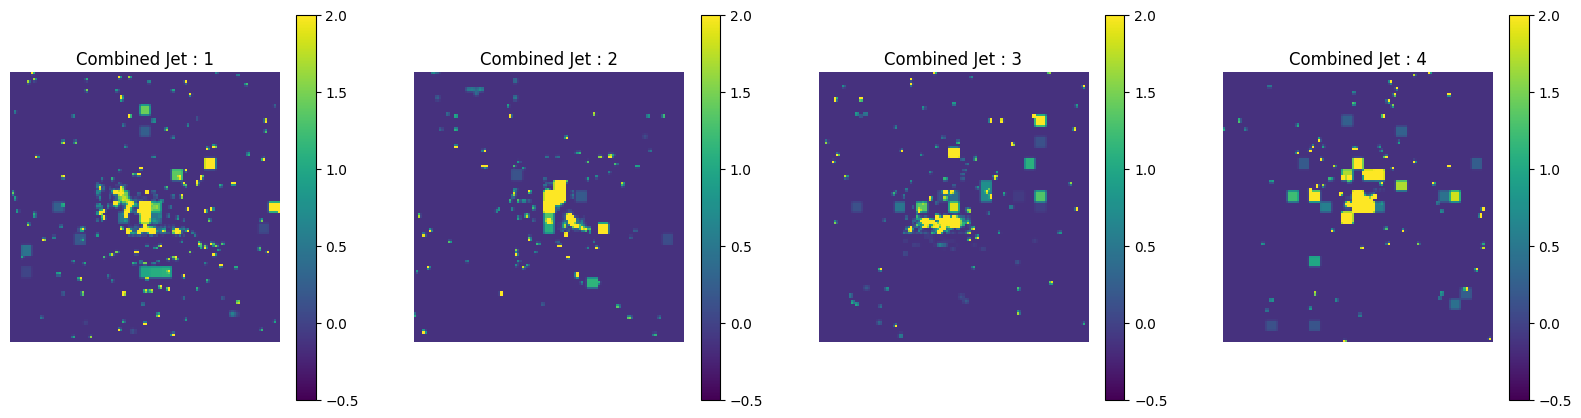

In [ ]:
plot_combined_images(combined,4)

## Splitting the data

In [ ]:
train_gen = ImageDataGenerator(validation_split = 0.2)

train_generator = train_gen.flow(x = X_jets, batch_size = 32, shuffle = True, seed = 42, subset = 'training')
valid_generator = train_gen.flow(x = X_jets, batch_size = 32, shuffle = True, seed = 42, subset = 'validation')

## Creating the sampling function and Loss function

In [ ]:
def Sampling(mu, sigma):
  #Generates a random sample and combines with the encoder output
  mu, sigma = mu, sigma
  batch = tf.shape(mu)[0]
  dim = tf.shape(mu)[1]
  epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
  z = mu + tf.exp(0.5 * sigma) * epsilon
  return  z

In [ ]:
def vae_loss(inputs, outputs, z_mean, z_sigma):
  reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs) * 128 * 128 * 3
  kl_loss = - 0.5 * (tf.reduce_mean(1+z_sigma-tf.square(z_mean)-tf.exp(z_sigma)))
  return reconstruction_loss + kl_loss

## Defining the first VAE Model

In [ ]:
# Define VAE architecture
latent_dim = 1024

# Define encoder model
encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)                     # Mean value of encoded input
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)               # Std. dev of encoded input

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")


# Define decoder model
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", strides=2, padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

print(encoder.summary())
print(decoder.summary())

# Define VAE model
outputs = decoder([Sampling(z_mean, z_log_var)])

vae = keras.Model(encoder_inputs, outputs, name="vae")

print(encoder_inputs.shape.as_list())
print(decoder_outputs.shape.as_list())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 64, 64, 32)           896       ['input_27[0][0]']            
                                                                                                  
 conv2d_37 (Conv2D)          (None, 32, 32, 64)           18496     ['conv2d_36[0][0]']           
                                                                                                  
 flatten_15 (Flatten)        (None, 65536)                0         ['conv2d_37[0][0]']           
                                                                                            

## Training and evaluation

In [ ]:
# Compile VAE model
vae.add_loss(vae_loss(encoder_inputs, outputs, z_mean, z_log_var))
# vae.compile(optimizer="adam")

optimizer = keras.optimizers.Adam(learning_rate=3e-4)
vae.compile(optimizer=optimizer)

# Train VAE model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

history = vae.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        epochs=20,
        validation_data=valid_generator,
        validation_steps=valid_generator.n // valid_generator.batch_size,
        callbacks=[es],
        verbose=1
)

Epoch 1/20
125/125 [==============================] - 305s 2s/step - loss: 5230.0947 - val_loss: 53.5278
Epoch 2/20
125/125 [==============================] - 310s 2s/step - loss: 40.9789 - val_loss: 31.7274
Epoch 3/20
125/125 [==============================] - 307s 2s/step - loss: 27.2547 - val_loss: 23.1847
Epoch 4/20
125/125 [==============================] - 306s 2s/step - loss: 20.8774 - val_loss: 18.5770
Epoch 5/20
125/125 [==============================] - 319s 3s/step - loss: 17.4114 - val_loss: 16.0250
Epoch 6/20
125/125 [==============================] - 330s 3s/step - loss: 15.3833 - val_loss: 14.4127
Epoch 7/20
125/125 [==============================] - 313s 2s/step - loss: 13.9581 - val_loss: 13.1877
Epoch 8/20
125/125 [==============================] - 323s 3s/step - loss: 12.8982 - val_loss: 12.2984
Epoch 9/20
125/125 [==============================] - 305s 2s/step - loss: 12.1313 - val_loss: 11.6515
Epoch 10/20
125/125 [==============================] - 304s 2s/step - l

In [ ]:
sample = X_jets[:5]

z_mean, z_sigma = encoder.predict(sample)
batch_size = 5
reconstructed_samples = decoder.predict(z_mean + np.exp(0.5 * z_sigma) * np.random.normal(size=(batch_size, latent_dim)))


1/1 [==============================] - 0s 150ms/step


In [ ]:
mean_track = np.mean(X_jets[:,:,:,0])
std_track = np.std(X_jets[:,:,:,0])
normalized_track = (X_jets[:,:,:,0] - mean_track) / std_track

mean_ecal = np.mean(X_jets[:,:,:,1])
std_ecal = np.std(X_jets[:,:,:,1])
normalized_ecal = (X_jets[:,:,:,1] - mean_ecal) / std_ecal

mean_hcal = np.mean(X_jets[:,:,:,2])
std_hcal = np.std(X_jets[:,:,:,2])
normalized_hcal = (X_jets[:,:,:,2] - mean_hcal) / std_hcal

X_jets_combined = normalized_track + normalized_ecal + normalized_hcal
print(X_jets_combined.shape)
print(X_jets_combined[0].shape)

X_jets_combined = np.expand_dims(X_jets_combined, axis=-1)  # Reshape to (n, 125, 125, 1)


(5000, 128, 128)
(128, 128)


In [ ]:
mean_track = np.mean(reconstructed_samples[:,:,:,0])
std_track = np.std(reconstructed_samples[:,:,:,0])
normalized_track = (reconstructed_samples[:,:,:,0] - mean_track) / std_track

mean_ecal = np.mean(reconstructed_samples[:,:,:,1])
std_ecal = np.std(reconstructed_samples[:,:,:,1])
normalized_ecal = (reconstructed_samples[:,:,:,1] - mean_ecal) / std_ecal

mean_hcal = np.mean(reconstructed_samples[:,:,:,2])
std_hcal = np.std(reconstructed_samples[:,:,:,2])
normalized_hcal = (reconstructed_samples[:,:,:,2] - mean_hcal) / std_hcal

reconstructed_samples = normalized_track + normalized_ecal + normalized_hcal

print(reconstructed_samples.shape)
print(reconstructed_samples[0].shape)

reconstructed_samples = np.expand_dims(reconstructed_samples, axis=-1)  # Reshape to (n, 125, 125, 1)

(5, 128, 128)
(128, 128)


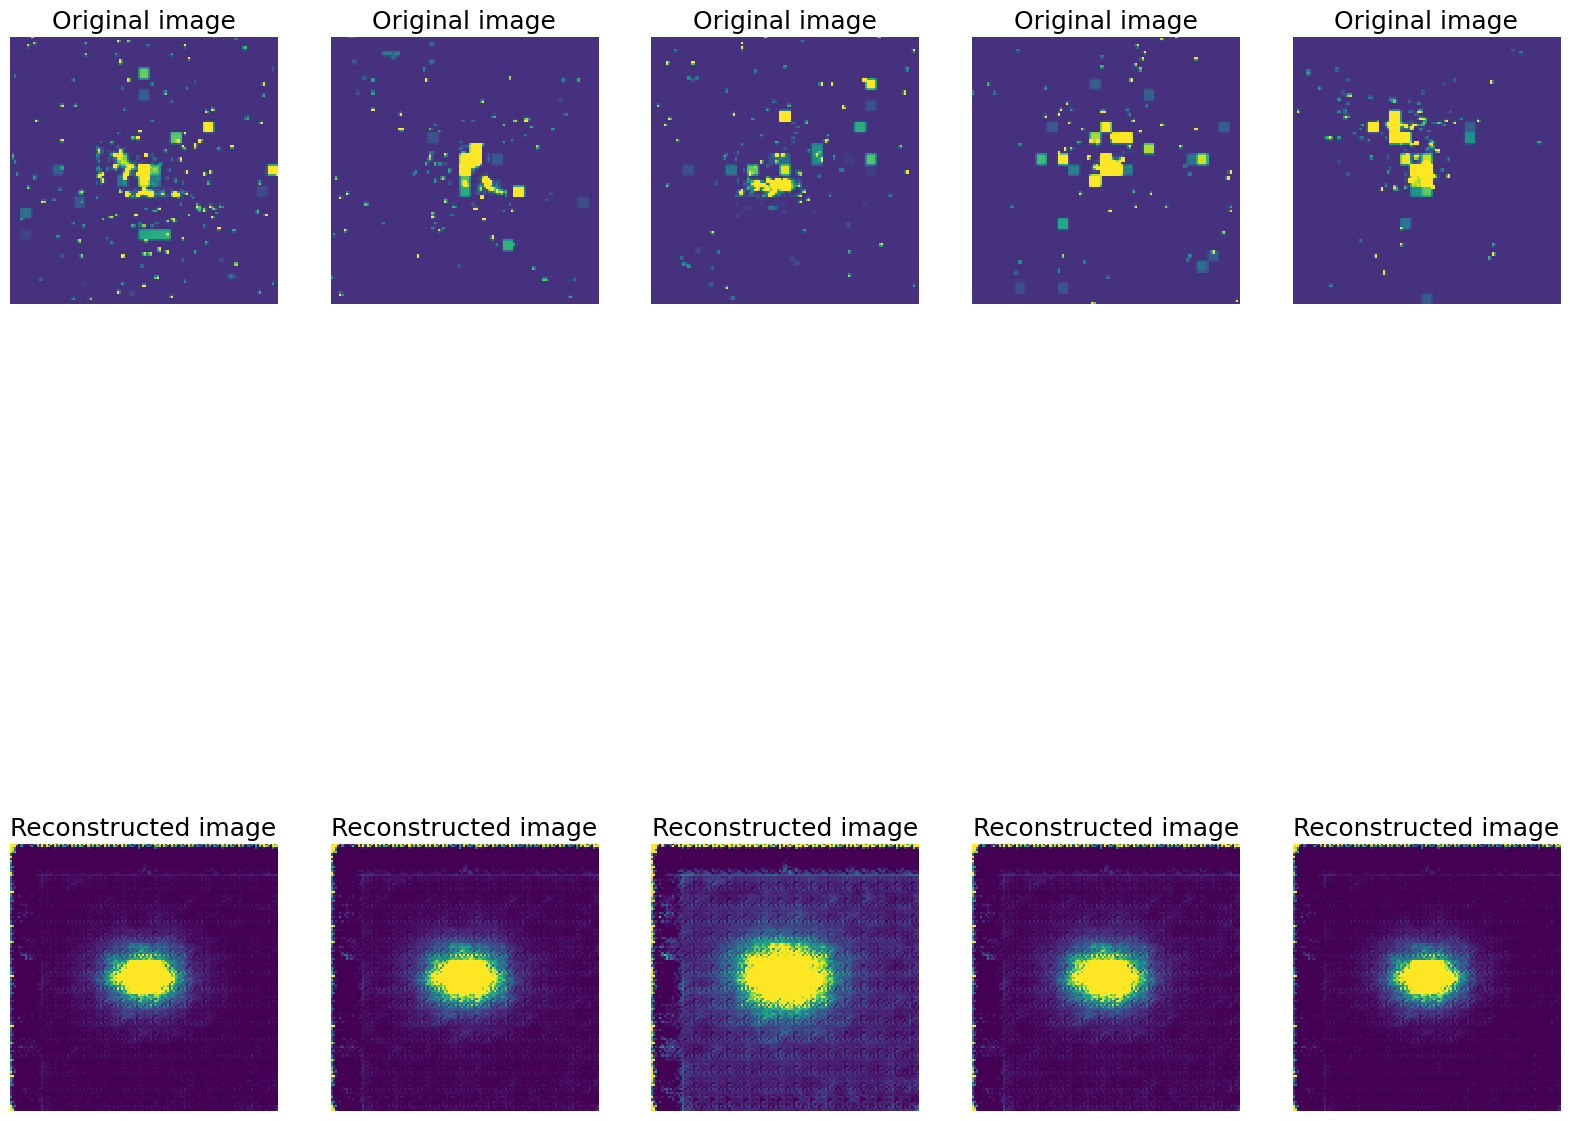

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 20))

for i in range(5):
    axes[0, i].imshow(X_jets_combined[i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original image', fontsize=18)  # Add label to the subplot

for i in range(5):
    axes[1, i].imshow(reconstructed_samples[i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[1, i].axis('off')
    axes[1, i].set_title('Reconstructed image', fontsize=18)  # Add label to the subplot

fig.subplots_adjust(hspace=0.1)
# plt.tight_layout()  # Reduce whitespace between subplots
plt.show()

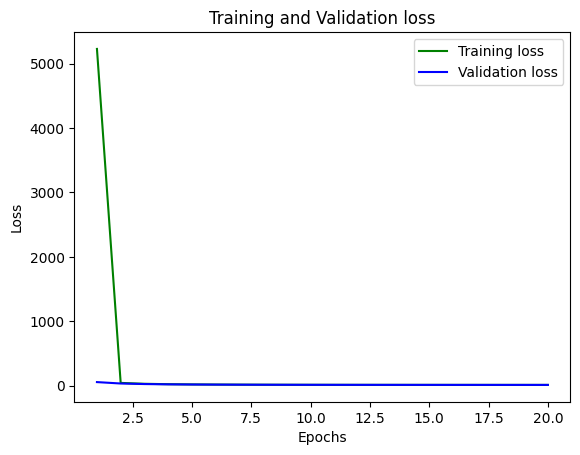

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(1, len(loss_train) + 1)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Conclusion:

As it can be seen from above the generate images are not very good. So reasons for that can be:
1.   Since this is not typical RGB data the model does not behave in a way that it would for an RGB data.
2.   Although traditional transformations can be applied but there is not much difference. For Example, Rotating a image won't do us any good as the data is kind of rotation invariate. Similar for other transformations.
3. Since all of the dataset wasn't used so the training wasn't perfect. There may be a scope of Overfitting.
4. The hyperparameters may not be right.

Ways to improve the model:



1.   Other Architectures need to be explore such as VQ-VAE or Beta-VAE.
2.   The hyperparamters should be tuned more.
3.   Other Generative models can be used to learn the representation such as Diffusion model etc.
4. Since the images are not the typical RGB images and based on research converting them to graph and applying Graph VAE may yield better results.



